In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [54]:
df = pd.read_csv("D:\PyProj\Learning\CC Fraud Detection\CC.csv", encoding='latin1')

In [55]:
df.columns

Index(['Unnamed: 0', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount', 'Class'],
      dtype='object')

In [57]:
df = df.drop(columns=['Unnamed: 0'])
df.info()

KeyError: "['Unnamed: 0'] not found in axis"

In [58]:
df.describe()
df.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [59]:
normal = df[df['Class']==0]
fraud = df[df['Class']==1]
print("Normal datapoints: ", normal.shape[0])
print("Fraud datapoints: ", fraud.shape[0])

Normal datapoints:  284315
Fraud datapoints:  492


In [60]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [61]:
fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

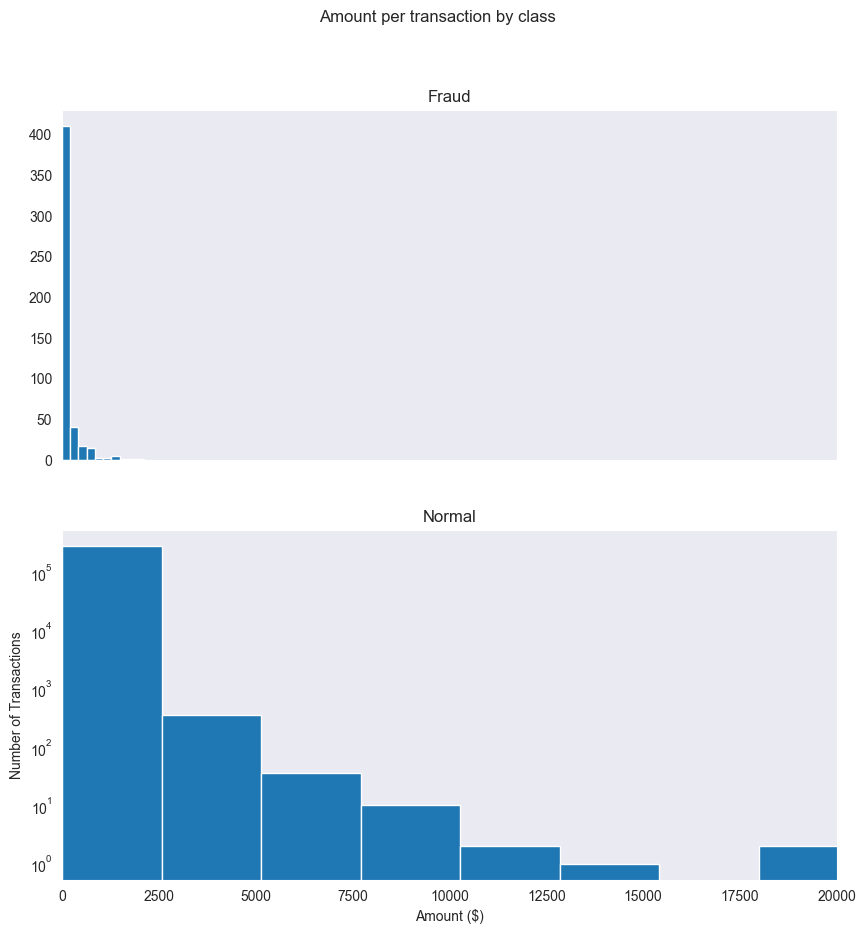

In [62]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10,10) )
f.suptitle('Amount per transaction by class')

bins = 10

ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

ax1.grid()
ax2.grid()
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

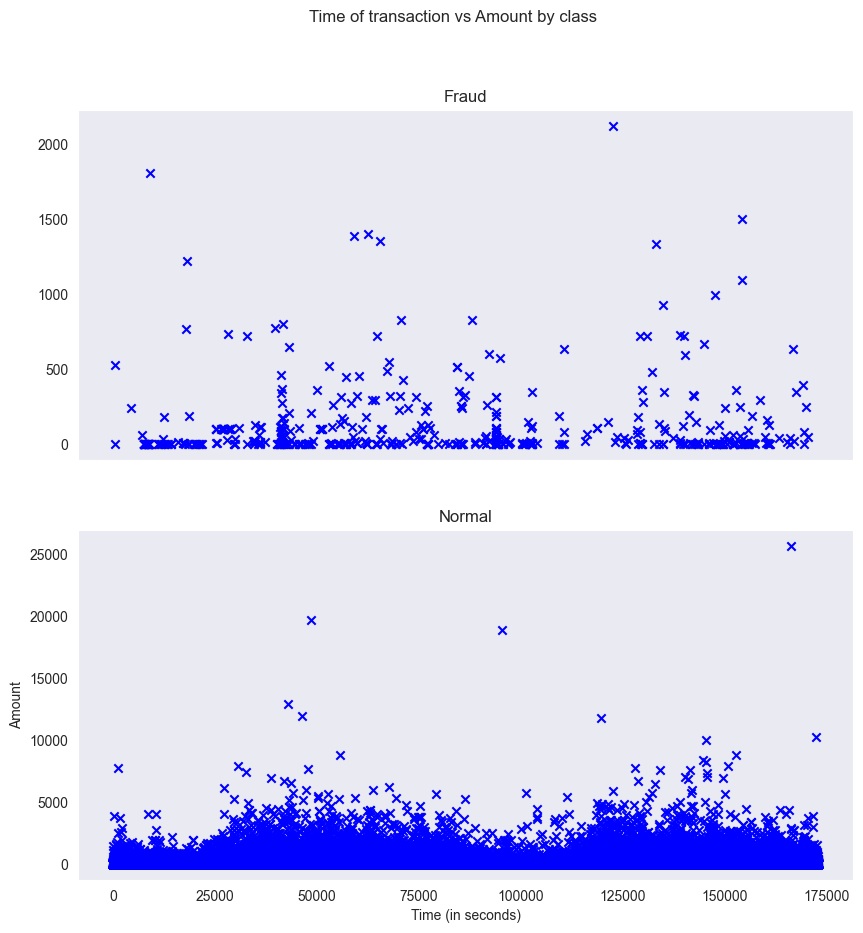

In [63]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10,10) )
fig.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud.Time, fraud.Amount, c='blue', marker='x')
ax1.set_title('Fraud')
ax1.grid()

ax2.scatter(normal.Time, normal.Amount, c='blue', marker='x')
ax2.set_title('Normal')
ax2.grid()
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()


In [64]:
data = df.drop(['Time'], axis =1)

In [65]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train
X_test = X_test
print(X_train.shape)

print(X_test.shape)
print(y_test.shape)

(227451, 29)
(56962, 29)
(56962,)


In [66]:
scaler = StandardScaler().fit(X_train.Amount.values.reshape(-1,1))
X_train['Amount'] = scaler.transform(X_train.Amount.values.reshape(-1,1))
X_test['Amount'] = scaler.transform(X_test.Amount.values.reshape(-1,1))

In [67]:
import tensorflow as tf
from tf_keras.layers import Dense, Dropout, Input
from tf_keras import regularizers
from tf_keras.models import Model, load_model
from tf_keras.callbacks import ModelCheckpoint, TensorBoard



In [68]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [69]:
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [70]:
X_train.shape

(227451, 29)

In [71]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    )

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.3,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
4976/4976 [==============================] - 6s 1ms/step - loss: 0.8250 - val_loss: 0.8173
Epoch 2/100
 185/4976 [>.............................] - ETA: 3s - loss: 0.7562

C:\Users\Windows 10\AppData\Roaming\Python\Python39\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4976/4976 [==============================] - 5s 1ms/step - loss: 0.7441 - val_loss: 0.7834
Epoch 3/100
4976/4976 [==============================] - 5s 998us/step - loss: 0.7230 - val_loss: 0.7685
Epoch 4/100
4976/4976 [==============================] - 5s 1ms/step - loss: 0.7130 - val_loss: 0.7618
Epoch 5/100
4976/4976 [==============================] - 6s 1ms/step - loss: 0.7072 - val_loss: 0.7559
Epoch 6/100
4976/4976 [==============================] - 6s 1ms/step - loss: 0.7045 - val_loss: 0.7552
Epoch 7/100
4976/4976 [==============================] - 6s 1ms/step - loss: 0.7025 - val_loss: 0.7523
Epoch 8/100
4976/4976 [==============================] - 6s 1ms/step - loss: 0.7014 - val_loss: 0.7513
Epoch 9/100
4976/4976 [==============================] - 6s 1ms/step - loss: 0.7003 - val_loss: 0.7490
Epoch 10/100
4976/4976 [==============================] - 6s 1ms/step - loss: 0.6996 - val_loss: 0.7489
Epoch 11/100
4976/4976 [==============================] - 6s 1ms/step - loss: 0.69

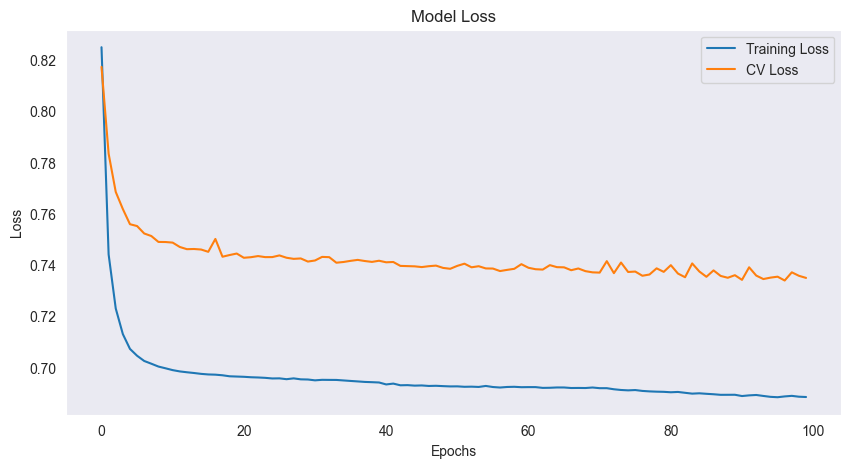

In [72]:
plt.figure(figsize = (10,5))
plt.plot(history['loss'], label = 'Training Loss')
plt.plot(history['val_loss'], label = 'CV Loss')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [73]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 1s 619us/step


In [74]:
predictions.shape

(56962, 29)

In [75]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class':y_test})

In [76]:
error_df.groupby(['true_class']).describe()

reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                       56864.0   0.683914   2.542116  0.044999  0.243273   
1                          98.0  29.797248  43.974093  0.127174  4.053550   

                                             
                 50%        75%         max  
true_class                                   
0           0.383422   0.607526  154.090603  
1           9.654601  49.937635  248.412262

C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


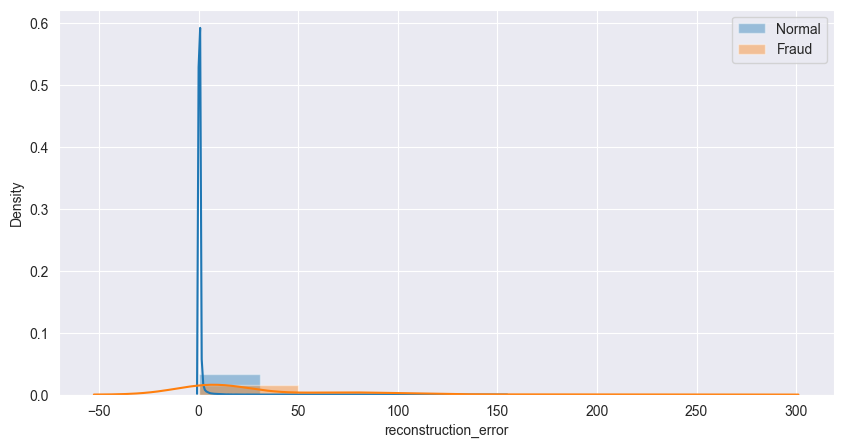

In [77]:
plt.figure(figsize = (10,5))
sns.distplot(error_df[error_df['true_class']==0]['reconstruction_error'], bins = 5, label = 'Normal')
sns.distplot(error_df[error_df['true_class']==1]['reconstruction_error'], bins=5, label = 'Fraud')
plt.legend()
plt.show()

In [78]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, roc_auc_score)

In [79]:
threshold = 1.4

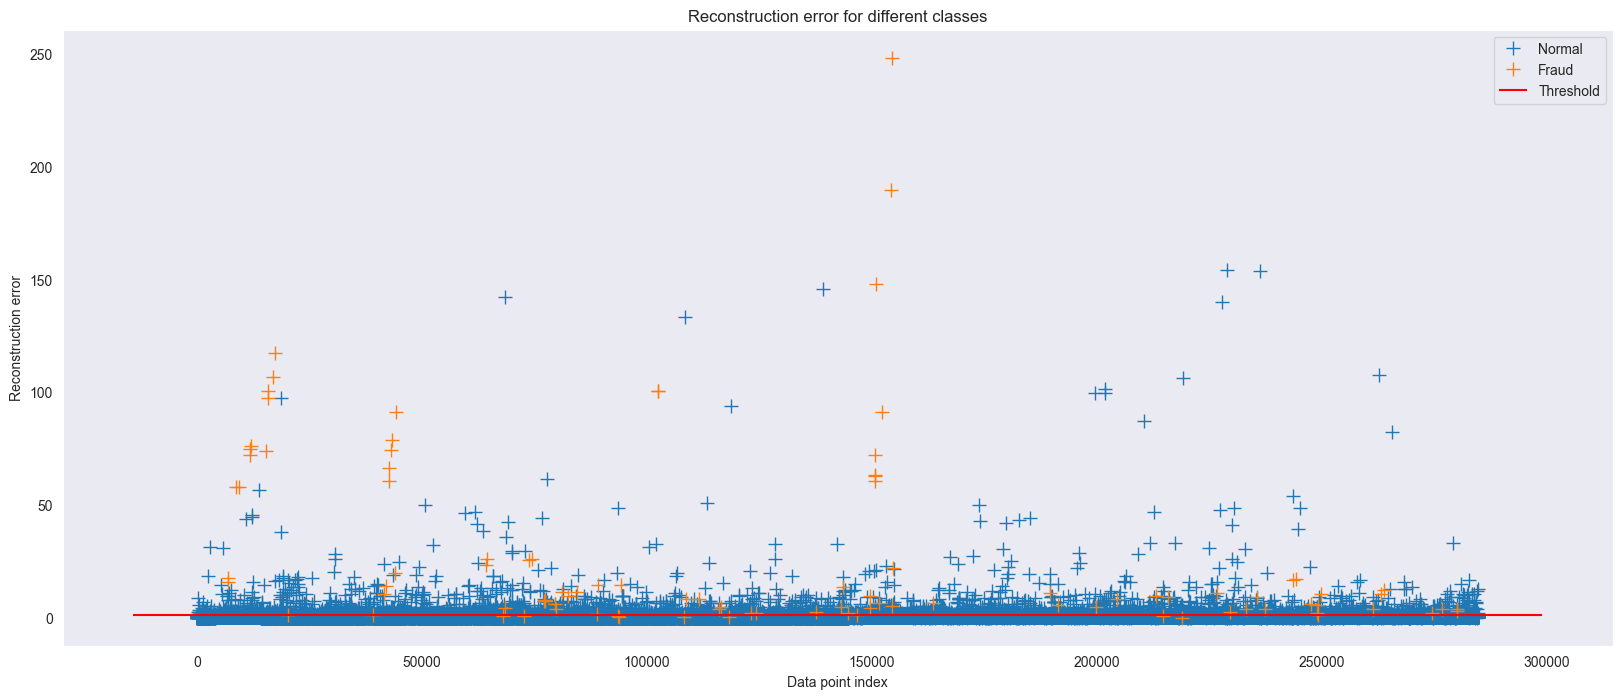

In [80]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize = (20,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='+', ms=10, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.grid()
plt.show();

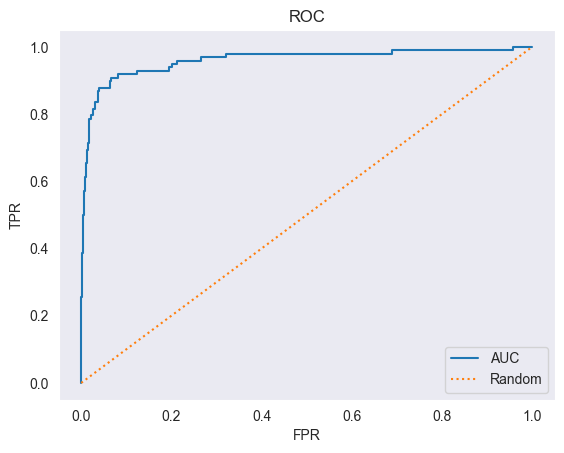

In [81]:
fpr, tpr, thres = roc_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(fpr, tpr, label = 'AUC') 
plt.plot([0,1], [0,1], ':', label = 'Random') 
plt.legend() 
plt.grid() 
plt.ylabel("TPR") 
plt.xlabel("FPR") 
plt.title('ROC') 
plt.show() 

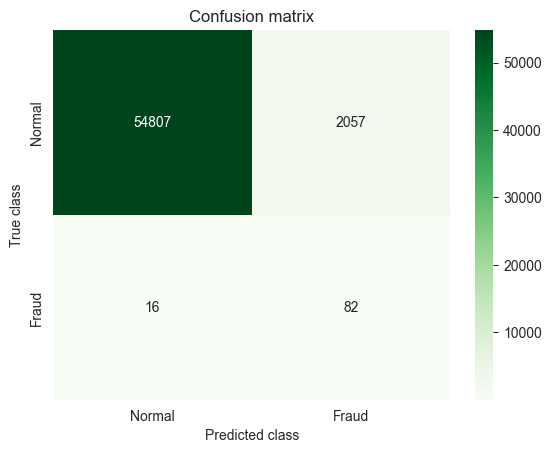

In [82]:
LABELS = ['Normal', 'Fraud']
threshold = 2
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Greens');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [83]:
## Chosen metric is AUC ROC as data is imbalanced
print("Area under ROC : ", roc_auc_score(error_df.true_class,y_pred ))

Area under ROC :  0.9002803323073744


In [84]:
print(classification_report(error_df.true_class,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.84      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.90      0.53     56962
weighted avg       1.00      0.96      0.98     56962

